<a href="https://colab.research.google.com/github/eladorpBG/ML_assignment4/blob/main/Flowers_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and extract the data

In [ ]:
from scipy.io import loadmat

# download dataset from link https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz
!tar -xvzf 102segmentations.tgz
!tar -xvzf 102flowers.tgz


# Upload pre-processed images (removed background) from google drive

The VGG19 model performed worse on images with the background removed compared to raw images, so we chose to use the raw images for this task. The next cell is included in the notebook to present the process we made.

In [ ]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')

zip_path = "/content/drive/My Drive/images.zip"
extract_path = "/content/images"

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
print(os.listdir(extract_path))

['images']


# Preprocessing

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import scipy.io
from PIL import Image
import os


# Define paths
# data_dir = "images/images"  # Directory with removed-background images
data_dir = "jpg"  # Directory with flower images
labels_file = "imagelabels.mat"

# Load labels
labels_mat = scipy.io.loadmat(labels_file)
labels = labels_mat["labels"].flatten() - 1  # Adjust labels to start from 0

# Transformation for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG19 input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ImageNet
])

# Custom Dataset
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.image_paths = sorted(os.listdir(data_dir))  # Ensure consistent order

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Load the dataset
dataset = FlowerDataset(data_dir, labels, transform=transform)

# Split dataset into train (50%), validation (25%), and test (25%)
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)


# Load and Modify VGG19

In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Freeze the convolutional layers
for param in vgg19.features.parameters():
    param.requires_grad = False

# Modify the classifier for 102 categories
vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # Input size is 25088 for VGG19
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 102),  # Output size is 102 categories
    nn.LogSoftmax(dim=1)  # Use LogSoftmax for probabilistic output
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)

# Training

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)

# epochs = 15  # Train to assess convergence and determine the optimal number of epochs for final training
epochs = 6  # 6 epochs in final training to prevent overfitting

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    # Initialize metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Call the train function
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    vgg19, train_loader, val_loader, criterion, optimizer, epochs
)

Epoch 1/6
Train Loss: 2.9169, Train Accuracy: 0.3661
Validation Loss: 1.4297, Validation Accuracy: 0.6273
Epoch 2/6
Train Loss: 1.2167, Train Accuracy: 0.6834
Validation Loss: 1.0380, Validation Accuracy: 0.7259
Epoch 3/6
Train Loss: 0.8212, Train Accuracy: 0.7787
Validation Loss: 1.0056, Validation Accuracy: 0.7474
Epoch 4/6
Train Loss: 0.6545, Train Accuracy: 0.8305
Validation Loss: 1.0365, Validation Accuracy: 0.7469
Epoch 5/6
Train Loss: 0.5272, Train Accuracy: 0.8620
Validation Loss: 0.9880, Validation Accuracy: 0.7636
Epoch 6/6
Train Loss: 0.4747, Train Accuracy: 0.8769
Validation Loss: 1.0347, Validation Accuracy: 0.7660


# Plot cross entropy loss of training and validation to observe learning process

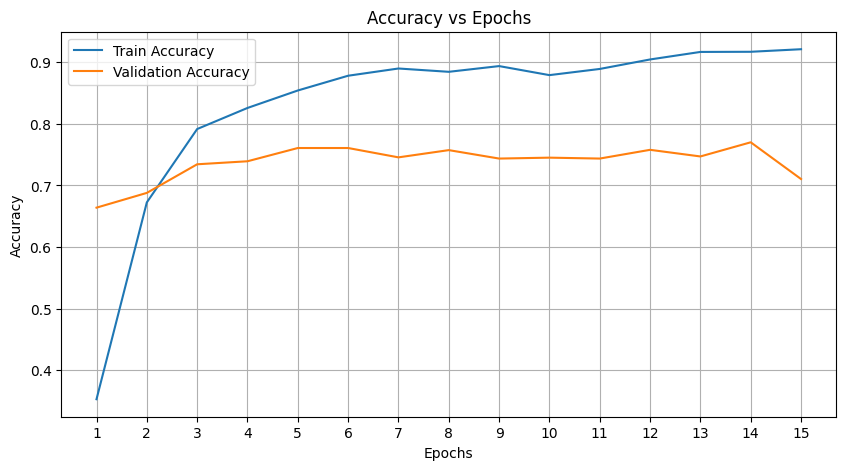

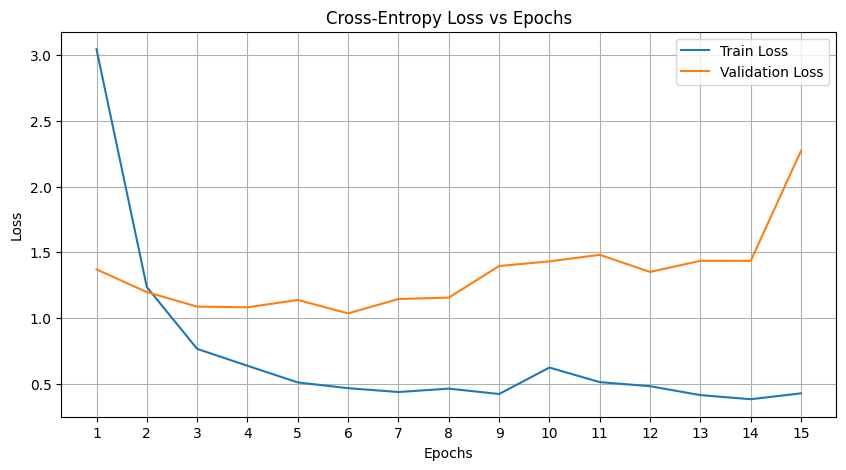

In [ ]:
import matplotlib.pyplot as plt

xticks = range(1, epochs + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(xticks, train_accuracies, label="Train Accuracy")
plt.plot(xticks, val_accuracies, label="Validation Accuracy")
plt.title("Accuracy vs Epochs")
plt.xticks(xticks)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Cross-Entropy Loss
plt.figure(figsize=(10, 5))
plt.plot(xticks, train_losses, label="Train Loss")
plt.plot(xticks, val_losses, label="Validation Loss")
plt.title("Cross-Entropy Loss vs Epochs")
plt.xticks(xticks)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


Since the model appeared to converge after 6 epochs, with validation accuracy plateauing and cross-entropy loss increasing afterward—indicating potential overfitting—we decided to retrain the final model using 6 epochs.

# Test

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(vgg19, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.1082, Test Accuracy: 0.7539


Plot accuracy and cross-entropy loss of train validation and test

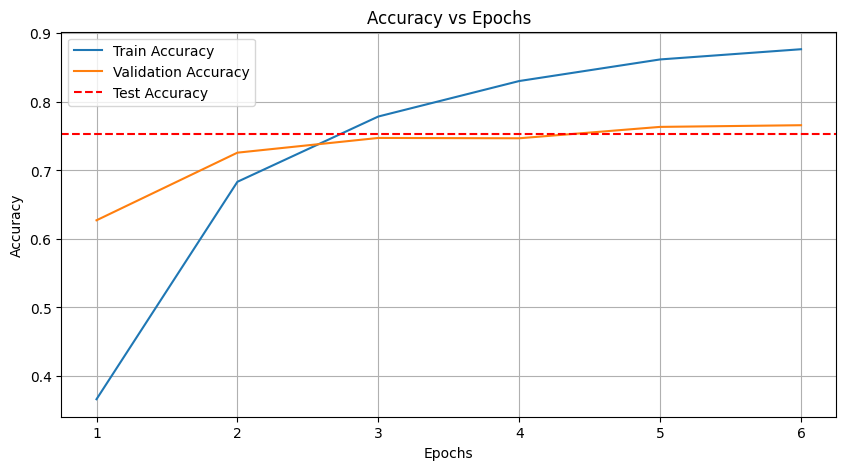

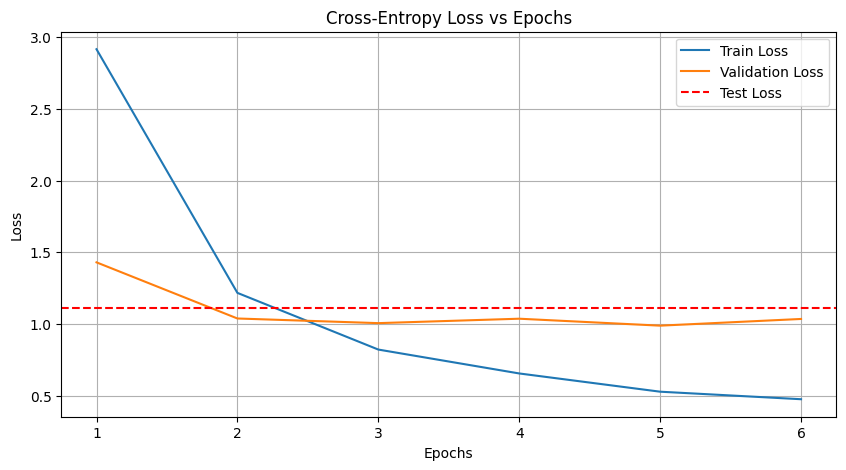

In [ ]:
import matplotlib.pyplot as plt

xticks = range(1, epochs + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(xticks, train_accuracies, label="Train Accuracy")
plt.plot(xticks, val_accuracies, label="Validation Accuracy")
plt.axhline(y=test_accuracy, color="r", linestyle="--", label="Test Accuracy")
plt.title("Accuracy vs Epochs")
plt.xticks(xticks)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Cross-Entropy Loss
plt.figure(figsize=(10, 5))
plt.plot(xticks, train_losses, label="Train Loss")
plt.plot(xticks, val_losses, label="Validation Loss")
plt.axhline(y=test_loss, color="r", linestyle="--", label="Test Loss")
plt.title("Cross-Entropy Loss vs Epochs")
plt.xticks(xticks)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()